In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io, transform
from sklearn import preprocessing
from tqdm.notebook import tqdm, trange
import anndata as ad
import tifffile
import pickle
from skimage.segmentation import relabel_sequential

In [2]:
p_dir = (Path().cwd().parents[0].parents[0]).absolute()
data_dir = p_dir / "09_datasets"

In [3]:
dataset_1 = data_dir / '01_codex_data'
dataset_2 = data_dir / '02_tissue_architecture'
dataset_3 = data_dir / '03_Sci_Data_Cycif' 
dataset_4 = data_dir / '04_codex_nature_pro' 
dataset_5 = data_dir / '05_MCMICRO' / 'TNP_pilot_cycif' 
dataset_7 = data_dir / '07_NIH' 
dataset_8 = data_dir / '08_visinity' 

masks_folder = data_dir / 'exported' / 'masks'
whole_mask_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'masks'

In [ ]:
from joblib import Parallel, delayed
from functools import partial
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from skimage import exposure

def contrast_streching(img):
    p2, p98 = np.percentile(img, (50, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)
    return img

def save_hdf5(
    path: str, name: str, data: np.ndarray, attr_dict=None, mode: str = "a"
) -> None:
    # Read h5 file
    hf = h5py.File(path, mode)
    # Create z_stack_dataset
    if hf.get(name) is None:
        data_shape = data.shape
        data_type = data.dtype
        chunk_shape = (1,) + data_shape[1:]
        max_shape = (data_shape[0],) + data_shape[1:]
        dset = hf.create_dataset(
            name,
            shape=data_shape,
            maxshape=max_shape,
            chunks=chunk_shape,
            dtype=data_type,
            compression="gzip",
        )
        dset[:] = data
        if attr_dict is not None:
            for attr_key, attr_val in attr_dict.items():
                dset.attrs[attr_key] = attr_val
    else:
        print(f"Dataset {name} exists")

    hf.close()
    
def get_imgs(file_path, name):
    f = h5py.File(file_path, "r")
    imgs = f[name]
    labels = list(f[name].attrs["labels"])
    return imgs, labels

def read_intensity_per_cell(img, marker, mask):
    props = skimage.measure.regionprops_table(
        mask, img, properties=["label", "mean_intensity"]
    )
    df_prop = pd.DataFrame(props)
    df_prop["mean_intensity"] = df_prop["mean_intensity"]
    df_prop.columns = ["Cell_label", marker]
    return df_prop

def get_info_name(name):
    info = name.split(' ')[1]
    info = info.split('_')
    if len(info) == 6:
        row = int(info[1][2:])
        col = int(info[0][2:])
        size_c = int(info[2][2:])
        size_r = int(info[3][2:])
        d = 1
    else:
        row = int(info[2][2:])
        col = int(info[1][2:])
        size_c = int(info[3][2:])
        size_r = int(info[4][2:])
        d = int(info[0][2:])
    return d, row, col, [size_r, size_c]

# Our data

In [6]:
raw_path = r'Y:\coskun-lab\Thomas\Leap\data\metadata\combined_semi_final.h5ad'
adata = ad.read_h5ad(raw_path)

In [7]:
adata.obs.Dataset.isin(['TS Donor A', 'TS Donor E', 'LN Donor A', 'LN Donor E'])

,ROI,Cell,Dataset,leiden,Phenotype_r1,Phenotype_r1_n,Phenotype
0,1,1,LN Donor A,32,Stroma,0,Stroma
1,1,2,LN Donor A,10,Stroma,0,Stroma
2,1,3,LN Donor A,29,Stroma,0,Stroma
3,1,4,LN Donor A,11,Stroma,0,Stroma
4,1,5,LN Donor A,20,nan,1,Stroma
...,...,...,...,...,...,...,...
999965,18,9208,TS Donor E,26,nan,1,myeloid-derived cells
999966,18,9209,TS Donor E,14,B-cells,4,B-cells
999967,18,9210,TS Donor E,19,H3K27me3 + B-cells,7,B-cells
999968,18,9211,TS Donor E,14,B-cells,4,B-cells


# Dataset 1

Codex public data. Cell segmented using combination of ilastik and cell profiler. The region are divided into different smaller fov

In [6]:
## Get imgs in hdf5 format

# Define saving location
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"01_imgs.hdf5"

# Read imgs 
img_folder = dataset_1 / 'Data' / 'codex_raw'
imgs = []
markers = []

if h5_data.exists():
    pass
else:
    for (dirpath, dirnames, filenames) in os.walk(img_folder):
        for name in sorted(filenames):
            path = os.path.join(dirpath, name)
            img = io.imread(path)

            imgs.append(img)
            markers.append(name.split('.')[0])

    imgs = np.stack(imgs)
    save_hdf5(h5_data, 'imgs', imgs, {"labels": markers})

In [7]:
# Create WSI 
masks_1_folder = masks_folder / '01_codex'
masks = []
coords = []

mask_path = whole_mask_folder / '01.hdf5'

if mask_path.exists():
    with h5py.File(mask_path, "r") as f:
        mask_sti = f['mask'][:]
else:
    for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
        for name in tqdm(sorted(filenames)):
            if 'tiff' not in name:
                continue

            # read mask
            path = os.path.join(dirpath, name)
            mask = io.imread(path)
            mask = mask.astype(np.uint32)
            
            # If non cell in mask pass
            if mask.max() == 0:
                continue

            # Get mask coords and size
            info = name.split(' ')[1]
            info = info.split('_')
            row = int(info[1][2:])
            col = int(info[0][2:])
            size = int(info[2][2:])

            masks.append(mask)
            coords.append((row, col))

    coords = np.array(coords)
    max_coords = np.max(coords, axis=0)

    mask_sti = np.zeros((max_coords[0]+size, max_coords[1]+size), np.uint32)
    max_counter = 0
    for i, coord in tqdm(enumerate(coords)):
        mask = np.where(masks[i]>0, masks[i] + max_counter, 0)
        mask_sti[coord[0]:coord[0]+size, coord[1]:coord[1]+size] = mask
        max_counter = np.max(mask_sti)
    mask_sti, _, _ = relabel_sequential(mask_sti)
    save_hdf5(mask_path, 'mask', mask_sti)    

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [37]:
# Create adata
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"01_imgs.hdf5"
masks = []
coords = []
cell_ids = []

df_all = []
centroids = []

imgs, markers = get_imgs(h5_data, 'imgs')

for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
    for name in tqdm(sorted(filenames)):
        if 'tiff' not in name:
            continue
        
        # read mask
        path = os.path.join(dirpath, name)
        mask = io.imread(path)
        
        # Get spatial info
        props = skimage.measure.regionprops_table(
            mask, properties=["label"]
        )
        cell_ids.append(np.array(props['label']))
        
        # If non cell in mask pass
        if mask.max() == 0:
            continue
        
        # Get mask coords and size
        info = name.split(' ')[1]
        info = info.split('_')
        row = int(info[1][2:])
        col = int(info[0][2:])
        size = int(info[2][2:])
        
        # Get corresponding multiplex images
        imgs_small = imgs[:, row:row+size, col:col+size]
        mask = mask_sti[row:row+size, col:col+size]
        masks.append(mask)
        coords.append((row, col))
        
        # Get single-cell 
        f_partial = partial(read_intensity_per_cell, mask=mask)
        df_props = Parallel()(delayed(f_partial)(img, markers[i]) for i,img in enumerate(imgs_small))
        
        df_cell_intensity = reduce(
            lambda left, right: pd.merge(left, right, on=["Cell_label"]),
            df_props,
        )
        df_cell_intensity["ROI"] = len(masks)
        df_all.append(df_cell_intensity)
        
        # Get spatial info
        props = skimage.measure.regionprops_table(
            mask, properties=["label", "centroid"]
        )
        rows = props["centroid-0"] + row
        cols = props["centroid-1"] + col 
        centroid = np.array(list(zip(cols, rows)))
        centroids.append(centroid)


  0%|          | 0/50 [00:00<?, ?it/s]

In [38]:
# Append data
df_intensity = pd.concat(df_all, ignore_index=True)
cent = np.concatenate(centroids)
cells_roi = np.concatenate(cell_ids)

# Create annData from dataframe
adata = sc.AnnData(df_intensity[markers].values)
adata.var_names = markers  # add variable name

# Add obs information
adata.obs["ROI"] = df_intensity.ROI.tolist()
adata.obs["Cell"] = df_intensity.Cell_label.tolist()
adata.obs['Cell_ROI'] = cells_roi
adata.obsm["spatial"] = np.array(cent)

path = (Path().cwd().parents[0]).absolute() / 'data'/ 'raw' / '01.h5ad'
adata.write(path)

C:\Users\thu71\AppData\Local\Temp\ipykernel_38836\3432692503.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df_intensity[markers].values)


In [15]:
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"01_imgs.hdf5"
imgs, markers = get_imgs(h5_data, 'imgs')


mask_path = whole_mask_folder / '01.hdf5'
with h5py.File(mask_path, "r") as f:
    mask_sti = f['mask'][:]

In [17]:
imgs_small = imgs[:, 3000:8000, 6000:11000]
mask_sti_small = mask_sti[3000:8000, 6000:11000]

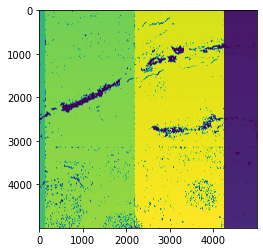

In [18]:
plt.imshow(mask_sti_small)

In [19]:
import napari
viewer = napari.view_image(imgs_small, channel_axis=0, name=markers, visible=False)
viewer.add_labels(mask_sti_small)

C:\Users\thu71\AppData\Roaming\Python\Python39\site-packages\napari\plugins\_plugin_manager.py:549: UserWarning: Plugin 'napari-crop' has already registered a function widget 'crop region' which has now been overwritten
  warn(message=warn_message)
C:\Users\thu71\.conda\envs\thomas-env\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'mask_sti_small' at 0x1fa2cabd340>

# Dataset 3

In [18]:
## Get imgs in hdf5 format

# Define saving location
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"03_imgs.hdf5"

if h5_data.exists():
    pass
else:
    # Read imgs 
    img_path = dataset_3 / 'DATASET-1' / 'TONSIL-1' / '10X' / 'OME_TIFF' / 'tonsil-1_10x.ome.tif'
    imgs = io.imread(img_path)
    
    # Read markers
    markers_path = dataset_3 / 'DATASET-1' / 'markers.csv'
    df = pd.read_csv(markers_path)
    markers = df.marker_name.tolist()

    assert len(df) == len(imgs)

    save_hdf5(h5_data, 'imgs', imgs, {"labels": markers})

In [20]:
masks_1_folder = masks_folder / '03_cycif'
masks = []
coords = []

mask_path = whole_mask_folder / '03.hdf5'

if mask_path.exists():
    with h5py.File(mask_path, "r") as f:
        mask_sti = f['mask'][:]
else:
    for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
        for name in tqdm(sorted(filenames)):
            if 'tiff' not in name:
                continue

            # read mask
            path = os.path.join(dirpath, name)
            mask = io.imread(path)
            mask = mask.astype(np.uint32)
            
            # If non cell in mask pass
            if mask.max() == 0:
                continue

            # Get mask coords and size
            info = name.split(' ')[1]
            info = info.split('_')
            row = int(info[1][2:])
            col = int(info[0][2:])
            size = int(info[2][2:])

            masks.append(mask)
            coords.append((row, col))

    coords = np.array(coords)
    max_coords = np.max(coords, axis=0)

    mask_sti = np.zeros((max_coords[0]+size, max_coords[1]+size), np.uint32)
    max_counter = 0
    for i, coord in tqdm(enumerate(coords)):
        mask = np.where(masks[i]>0, masks[i] + max_counter, 0)
        mask_sti[coord[0]:coord[0]+size, coord[1]:coord[1]+size] = mask
        max_counter = np.max(mask_sti)
    mask_sti, _, _ = relabel_sequential(mask_sti)
    save_hdf5(mask_path, 'mask', mask_sti)    

In [21]:
# Create adata
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"03_imgs.hdf5"
masks = []
coords = []
cell_ids = []

df_all = []
centroids = []

imgs, markers = get_imgs(h5_data, 'imgs')

for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
    for name in tqdm(sorted(filenames)):
        if 'tiff' not in name:
            continue
        
        # read mask
        path = os.path.join(dirpath, name)
        mask = io.imread(path)
        
        # If non cell in mask pass
        if mask.max() == 0:
            continue
        
        # Get spatial info
        props = skimage.measure.regionprops_table(
            mask, properties=["label"]
        )
        cell_ids.append(np.array(props['label']))
        

        
        # Get mask coords and size
        info = name.split(' ')[1]
        info = info.split('_')
        row = int(info[1][2:])
        col = int(info[0][2:])
        size = int(info[2][2:])
        
        # Get corresponding multiplex images
        imgs_small = imgs[:, row:row+size, col:col+size]
        mask = mask_sti[row:row+size, col:col+size]
        masks.append(mask)
        coords.append((row, col))
        
        # Get single-cell 
        f_partial = partial(read_intensity_per_cell, mask=mask)
        df_props = Parallel()(delayed(f_partial)(img, markers[i]) for i,img in enumerate(imgs_small))
        
        df_cell_intensity = reduce(
            lambda left, right: pd.merge(left, right, on=["Cell_label"]),
            df_props,
        )
        df_cell_intensity["ROI"] = len(masks)
        df_all.append(df_cell_intensity)
        
        # Get spatial info
        props = skimage.measure.regionprops_table(
            mask, properties=["label", "centroid"]
        )
        rows = props["centroid-0"] + row
        cols = props["centroid-1"] + col 
        centroid = np.array(list(zip(cols, rows)))
        centroids.append(centroid)


  0%|          | 0/55 [00:00<?, ?it/s]

In [22]:
# Append data
df_intensity = pd.concat(df_all, ignore_index=True)
cent = np.concatenate(centroids)
cells_roi = np.concatenate(cell_ids)

# Create annData from dataframe
adata = sc.AnnData(df_intensity[markers].values)
adata.var_names = markers  # add variable name

# Add obs information
adata.obs["ROI"] = df_intensity.ROI.tolist()
adata.obs["Cell"] = df_intensity.Cell_label.tolist()
adata.obs['Cell_ROI'] = cells_roi
adata.obsm["spatial"] = np.array(cent)

path = (Path().cwd().parents[0]).absolute() / 'data'/ 'raw' / '03.h5ad'
adata.write(path)

C:\Users\thu71\AppData\Local\Temp\ipykernel_17832\1930917565.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df_intensity[markers].values)


# Dataset 5

In [7]:
## Get imgs in hdf5 format

# Define saving location
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"05_imgs.hdf5"

if h5_data.exists():
    pass
else:
    print('Reading images')
    # Read imgs 
    img_path = dataset_5 / 'registration' / 'tnp_pilot_cycif.ome.tif'
    imgs = io.imread(img_path)
    
    # Read markers
    markers_path = dataset_5 / 'markers.csv'
    df = pd.read_csv(markers_path, header = None)

    assert len(df) == len(imgs)

    markers = df.iloc[:,0].tolist()
    
    print('Saving images')
    save_hdf5(h5_data, 'imgs', imgs, {"labels": markers})

In [8]:
masks_1_folder = masks_folder / '05_cycif'
masks = []
coords = []

mask_path = whole_mask_folder / '05_v1.hdf5'

if mask_path.exists():
    with h5py.File(mask_path, "r") as f:
        mask_sti = f['mask'][:]
else:
    for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
        for name in tqdm(sorted(filenames)):
            if 'tiff' not in name:
                continue

            # read mask
            path = os.path.join(dirpath, name)
            mask = io.imread(path)
            mask = mask.astype(np.uint32)
            
            # If non cell in mask pass
            if mask.max() == 0:
                continue

            # Get mask coords and size
            info = name.split(' ')[4]
            info = info.split('_')
            row = int(info[1][2:])
            col = int(info[0][2:])
            size = int(info[2][2:])

            masks.append(mask)
            coords.append((row, col))

    coords = np.array(coords)
    max_coords = np.max(coords, axis=0)

    mask_sti = np.zeros((max_coords[0]+size, max_coords[1]+size), np.uint32)
    max_counter = 0
    for i, coord in tqdm(enumerate(coords)):
        mask = np.where(masks[i]>0, masks[i] + max_counter, 0)
        mask_sti[coord[0]:coord[0]+size, coord[1]:coord[1]+size] = mask
        max_counter = np.max(mask_sti)
    mask_sti, _, _ = relabel_sequential(mask_sti)
    save_hdf5(mask_path, 'mask', mask_sti)    

In [13]:
# Create adata
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"05_imgs.hdf5"
masks = []
coords = []
cell_ids = []

df_all = []
centroids = []

imgs, markers = get_imgs(h5_data, 'imgs')

for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
    for name in tqdm(sorted(filenames)):
        if 'tiff' not in name:
            continue
        
        # read mask
        path = os.path.join(dirpath, name)
        mask = io.imread(path)
        
        # If non cell in mask pass
        if mask.max() == 0:
            continue
        
        # Get spatial info
        props = skimage.measure.regionprops_table(
            mask, properties=["label"]
        )
        cell_ids.append(np.array(props['label']))
        

        # Get mask coords and size
        info = name.split(' ')[4]
        info = info.split('_')
        row = int(info[1][2:])
        col = int(info[0][2:])
        size = int(info[2][2:])

        # Get corresponding multiplex images
        imgs_small = imgs[:, row:row+size, col:col+size]
        mask = mask_sti[row:row+size, col:col+size]
        masks.append(mask)
        coords.append((row, col))
        
        # Get single-cell 
        f_partial = partial(read_intensity_per_cell, mask=mask)
        df_props = Parallel()(delayed(f_partial)(img, markers[i]) for i,img in enumerate(imgs_small))
        
        df_cell_intensity = reduce(
            lambda left, right: pd.merge(left, right, on=["Cell_label"]),
            df_props,
        )
        df_cell_intensity["ROI"] = len(masks)
        df_all.append(df_cell_intensity)
        
        # Get spatial info
        props = skimage.measure.regionprops_table(
            mask, properties=["label", "centroid"]
        )
        rows = props["centroid-0"] + row
        cols = props["centroid-1"] + col 
        centroid = np.array(list(zip(cols, rows)))
        centroids.append(centroid)


  0%|          | 0/70 [00:00<?, ?it/s]

In [15]:
# Append data
df_intensity = pd.concat(df_all, ignore_index=True)
cent = np.concatenate(centroids)
cells_roi = np.concatenate(cell_ids)

# Create annData from dataframe
adata = sc.AnnData(df_intensity[markers].values)
adata.var_names = markers  # add variable name

# Add obs information
adata.obs["ROI"] = df_intensity.ROI.tolist()
adata.obs["Cell"] = df_intensity.Cell_label.tolist()
adata.obs['Cell_ROI'] = cells_roi
adata.obsm["spatial"] = np.array(cent)

path = (Path().cwd().parents[0]).absolute() / 'data'/ 'raw' / '05_v1.h5ad'
adata.write(path)

C:\Users\thu71\AppData\Local\Temp\ipykernel_46796\192837044.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df_intensity[markers].values)


## Transform csv file for source

In [59]:
csv_path = dataset_5 / 'quantification' / 'unmicst-tnp_pilot_cycif.csv'
df = pd.read_csv(csv_path)

print(df.columns)

Index(['CellID', 'A488_cellMask', 'A555_cellMask', 'A647_cellMask',
       'Hoechst2_cellMask', 'anti_NaKATPase_cellMask', 'anti_CD3_cellMask',
       'anti_CD45RO_cellMask', 'Hoechst3_cellMask', 'Ki67_488_cellMask',
       'Keratin_570_cellMask', 'aSMA_660_cellMask', 'Hoechst4_cellMask',
       'CD8a_488_cellMask', 'CD4_570_cellMask', 'CD45_647_cellMask',
       'Hoechst5_cellMask', 'CD20_488_cellMask', 'CD11c_555_cellMask',
       'PD1_647_cellMask', 'Hoechst6_cellMask', 'CD68_488_cellMask',
       'FOXP3_570_cellMask', 'PDL1_647_cellMask', 'Hoechst7_cellMask',
       'CD163_488_cellMask', 'H3_PE_cellMask', 'CD31_647_cellMask',
       'Hoechst8_cellMask', 'Ecad_488_cellMask', 'Vimentin_555_cellMask',
       'Catenin_647_cellMask', 'Hoechst9_cellMask', 'LaminAC_488_cellMask',
       'pH3_555_cellMask', 'H2ax_647_cellMask', 'X_centroid', 'Y_centroid',
       'column_centroid', 'row_centroid', 'Area', 'MajorAxisLength',
       'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Or

In [60]:
name = df.columns.tolist()
name = [n.replace('_cellMask','') for n in name]

In [63]:
protein_columns = ['A488_cellMask', 'A555_cellMask', 'A647_cellMask',
       'Hoechst2_cellMask', 'anti_NaKATPase_cellMask', 'anti_CD3_cellMask',
       'anti_CD45RO_cellMask', 'Hoechst3_cellMask', 'Ki67_488_cellMask',
       'Keratin_570_cellMask', 'aSMA_660_cellMask', 'Hoechst4_cellMask',
       'CD8a_488_cellMask', 'CD4_570_cellMask', 'CD45_647_cellMask',
       'Hoechst5_cellMask', 'CD20_488_cellMask', 'CD11c_555_cellMask',
       'PD1_647_cellMask', 'Hoechst6_cellMask', 'CD68_488_cellMask',
       'FOXP3_570_cellMask', 'PDL1_647_cellMask', 'Hoechst7_cellMask',
       'CD163_488_cellMask', 'H3_PE_cellMask', 'CD31_647_cellMask',
       'Hoechst8_cellMask', 'Ecad_488_cellMask', 'Vimentin_555_cellMask',
       'Catenin_647_cellMask', 'Hoechst9_cellMask', 'LaminAC_488_cellMask',
       'pH3_555_cellMask', 'H2ax_647_cellMask']
                   
protein_name = ['A488', 'A555', 'A647', 'Hoechst2', 'anti_NaKATPase', 'anti_CD3', 'anti_CD45RO', 'Hoechst3', 'Ki67_488', 
                'Keratin_570', 'aSMA_660', 'Hoechst4', 'CD8a_488', 'CD4_570', 'CD45_647', 'Hoechst5', 'CD20_488', 
                'CD11c_555', 'PD1_647', 'Hoechst6', 'CD68_488', 'FOXP3_570', 'PDL1_647', 'Hoechst7', 'CD163_488', 
                'H3_PE', 'CD31_647', 'Hoechst8', 'Ecad_488', 'Vimentin_555', 'Catenin_647', 'Hoechst9', 'LaminAC_488', 
                'pH3_555', 'H2ax_647']

meta_columns = ['CellID', 'Area', 'MajorAxisLength',
       'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation']

meta = ['Cell', 'Area', 'MajorAxisLength',
       'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation']

In [64]:
x = df['X_centroid'].to_numpy().astype(int)
y = df['Y_centroid'].to_numpy().astype(int)

spatial = np.vstack([x, y]).T

In [65]:
adata = ad.AnnData(df[protein_columns].values)
adata.var_names = protein_name
adata.obs = df[meta_columns]
adata.obs.columns = meta
adata.obsm['spatial'] = spatial

C:\Users\thu71\AppData\Local\Temp\ipykernel_17832\1349207622.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(df[protein_columns].values)


In [66]:
path = (Path().cwd().parents[0]).absolute() / 'data'/ 'raw' / '05.h5ad'
adata.write(path)

### Save mask

In [69]:
import cv2

In [80]:
mask_path = r'Y:\coskun-lab\Thomas\09_datasets\05_MCMICRO\TNP_pilot_cycif\segmentation\unmicst-TNP_pilot_cycif\cellmask.tif'
mask = io.imread(mask_path)

mask_path = whole_mask_folder / '05.hdf5'
save_hdf5(mask_path, 'mask', mask) 

# Dataset 7

In [23]:
## Get imgs in hdf5 format

# Define saving location
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"07_imgs.hdf5"

if h5_data.exists():
    pass
else:
    # Read markers
    markers_path = dataset_7 / 'markers.csv'
    df = pd.read_csv(markers_path)
    
    # Read imgs 
    img_folder = dataset_7 / 'ome-tiff'
    ids = []
    
    for (dirpath, dirnames, filenames) in os.walk(img_folder):
        for fname in sorted(filenames):
            path = os.path.join(dirpath, fname)
            imgs = io.imread(path)

            img_id = fname.split('.')[0]
            try:
                markers = df[img_id].tolist()
                markers = markers[:len(imgs)]
            except:
                continue

            save_hdf5(h5_data, img_id, imgs, {"labels": markers})

In [24]:
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"07_imgs.hdf5"
with h5py.File(h5_data) as f:
    datasets = list(f.keys())  # works like a dict

for i, dataset in tqdm(enumerate(datasets), total=len(datasets)):
    mask_path = whole_mask_folder / f'07_{dataset}.hdf5'
    if mask_path.exists():
        # with h5py.File(mask_path, "r") as f:
        #     mask_sti = f['mask'][:]
        pass
    else:
        masks_1_folder = masks_folder / f'07_{dataset}'
        masks = []
        coords = []
        sizes = []
        
        for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
            for name in tqdm(sorted(filenames)):
                if 'tiff' not in name:
                    continue

                # read mask
                path = os.path.join(dirpath, name)
                mask = io.imread(path)
                mask = mask.astype(np.uint32)

                # If non cell in mask pass
                if mask.max() == 0:
                    continue

                # Get mask coords and size
                d, row, col, size = get_info_name(name)

                masks.append(mask)
                coords.append((row, col))
                sizes.append(mask.shape)

        coords = np.array(coords) // d
        sizes = np.array(sizes)

        max_coords = np.max(coords, axis=0)
        sizes_r = sizes[np.argmax(coords, axis=0)[0]][0]
        sizes_c = sizes[np.argmax(coords, axis=0)[0]][1]

        mask_sti = np.zeros((max_coords[0]+sizes_r, max_coords[1]+sizes_c), np.uint32)
        max_counter = 0
        for i, coord in tqdm(enumerate(coords)):
            mask = np.where(masks[i]>0, masks[i] + max_counter, 0)
            s_r = sizes[i][0]
            s_c = sizes[i][1]
            mask_sti[coord[0]:coord[0]+ s_r, coord[1]:coord[1]+ s_c] = mask
            max_counter = np.max(mask_sti)
        mask_sti, _, _ = relabel_sequential(mask_sti)
        save_hdf5(mask_path, 'mask', mask_sti)    

  0%|          | 0/12 [00:00<?, ?it/s]

In [49]:
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"07_imgs.hdf5"
with h5py.File(h5_data) as f:
    datasets = list(f.keys())  # works like a dict

adatas = []
    
for i, dataset in tqdm(enumerate(datasets), total=len(datasets)):
    mask_path = whole_mask_folder / f'07_{dataset}.hdf5'
    with h5py.File(mask_path, "r") as f:
        mask_sti = f['mask'][:]
        
    masks_1_folder = masks_folder / f'07_{dataset}'
    
    masks = []
    coords = []
    sizes = []
    cell_ids = []
    
    df_all = []
    centroids = []

    imgs, markers = get_imgs(h5_data, dataset)

    for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
        for name in tqdm(sorted(filenames)):
            if 'tiff' not in name:
                continue

            # read mask
            path = os.path.join(dirpath, name)
            mask = io.imread(path)

            # If non cell in mask pass
            if mask.max() == 0:
                continue

            # Get spatial info
            props = skimage.measure.regionprops_table(
                mask, properties=["label"]
            )
            cell_ids.append(np.array(props['label']))

            # Get mask coords and size
            d, row, col, size = get_info_name(name)
            
            # Get corresponding multiplex images
            imgs_small = imgs[:, row:row+size[0], col:col+size[1]]
            imgs_small = transform.resize(imgs_small, (len(imgs), mask.shape[0], mask.shape[1]), 
                                          anti_aliasing=True)
            
            size = mask.shape
            row = row // d 
            col = col // d
            
            mask = mask_sti[row:row+size[0], col:col+size[1]]
            sizes.append(mask.shape)
            masks.append(mask)
            coords.append((row, col))

            # Get single-cell 
            f_partial = partial(read_intensity_per_cell, mask=mask)
            df_props = Parallel()(delayed(f_partial)(img, markers[i]) for i,img in enumerate(imgs_small))

            df_cell_intensity = reduce(
                lambda left, right: pd.merge(left, right, on=["Cell_label"]),
                df_props,
            )
            df_cell_intensity["ROI"] = len(masks)
            df_all.append(df_cell_intensity)

            # Get spatial info
            props = skimage.measure.regionprops_table(
                mask, properties=["label", "centroid"]
            )
            rows = props["centroid-0"] + row
            cols = props["centroid-1"] + col 
            centroid = np.array(list(zip(cols, rows)))
            centroids.append(centroid)
            
    # Append data
    df_intensity = pd.concat(df_all, ignore_index=True)
    cent = np.concatenate(centroids)
    cells_roi = np.concatenate(cell_ids)

    # Create annData from dataframe
    adata = sc.AnnData(df_intensity[markers].values)
    adata.var_names = markers  # add variable name

    # Add obs information
    adata.obs["ROI"] = df_intensity.ROI.tolist()
    adata.obs["Cell"] = df_intensity.Cell_label.tolist()
    adata.obs['Cell_ROI'] = cells_roi
    adata.obsm["spatial"] = np.array(cent)
    adata.obs['Dataset'] = dataset
    adatas.append(adata)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Local\Temp\ipykernel_17832\3513332648.py:86: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df_intensity[markers].values)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

In [50]:
adata = ad.concat(adatas)

path = (Path().cwd().parents[0]).absolute() / 'data'/ 'raw' / '07.h5ad'
adata.write(path)

C:\Users\thu71\.conda\envs\thomas-env\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Dataset 8

In [51]:
## Get imgs in hdf5 format

# Define saving location
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"08_imgs.hdf5"

if h5_data.exists():
    pass
else:
    # Read imgs 
    img_path = dataset_8 / 'raw' / 'ton_378_cropped.ome.tif' 
    imgs = io.imread(img_path)
    
    # Read markers
    markers_path = dataset_8 / 'raw' / 'markers.csv'
    df = pd.read_csv(markers_path)

    assert len(df) == len(imgs)

    markers = df.marker_name.tolist()

    save_hdf5(h5_data, 'imgs', imgs, {"labels": markers})

In [52]:
masks_1_folder = masks_folder / '08_visinity'
masks = []
coords = []
sizes = []

mask_path = whole_mask_folder / '08.hdf5'

if mask_path.exists():
    with h5py.File(mask_path, "r") as f:
        mask_sti = f['mask'][:]
else:
    for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
        for name in tqdm(sorted(filenames)):
            if 'tiff' not in name:
                continue

            # read mask
            path = os.path.join(dirpath, name)
            mask = io.imread(path)
            mask = mask.astype(np.uint32)
            
            # If non cell in mask pass
            if mask.max() == 0:
                continue

            ## Get mask coords and size
            d, row, col, size = get_info_name(name)

            masks.append(mask)
            coords.append((row, col))
            sizes.append(size)
    coords = np.array(coords)
    sizes = np.array(sizes)
    
    max_coords = np.max(coords, axis=0)
    sizes_r = sizes[np.argmax(coords, axis=0)[0]][0]
    sizes_c = sizes[np.argmax(coords, axis=0)[0]][1]

    mask_sti = np.zeros((max_coords[0]+sizes_r, max_coords[1]+sizes_c), np.uint32)
    max_counter = 0
    for i, coord in tqdm(enumerate(coords)):
        mask = np.where(masks[i]>0, masks[i] + max_counter, 0)
        s_r = sizes[i][0]
        s_c = sizes[i][1]
        mask_sti[coord[0]:coord[0]+ s_r, coord[1]:coord[1]+ s_c] = mask
        max_counter = np.max(mask_sti)
    mask_sti, _, _ = relabel_sequential(mask_sti)
    save_hdf5(mask_path, 'mask', mask_sti)    

In [56]:
# Create adata
h5_data = (Path().cwd().parents[0]).absolute() / 'data'/ 'GC Database' / f"08_imgs.hdf5"
masks = []
coords = []
cell_ids = []

df_all = []
centroids = []

imgs, markers = get_imgs(h5_data, 'imgs')

for (dirpath, dirnames, filenames) in os.walk(masks_1_folder):
    for name in tqdm(sorted(filenames)):
        if 'tiff' not in name:
            continue
        
        # read mask
        path = os.path.join(dirpath, name)
        mask = io.imread(path)
        
        # If non cell in mask pass
        if mask.max() == 0:
            continue
            
        # Get spatial info
        props = skimage.measure.regionprops_table(
            mask, properties=["label"]
        )
        cell_ids.append(np.array(props['label']))
        
        # Get mask coords and size
        d, row, col, size = get_info_name(name)
        
        # Get corresponding multiplex images
        imgs_small = imgs[:, row:row+size[0], col:col+size[1]]
        mask = mask_sti[row:row+size[0], col:col+size[1]]
        masks.append(mask)
        coords.append((row, col))
        
        # Get single-cell 
        f_partial = partial(read_intensity_per_cell, mask=mask)
        df_props = Parallel()(delayed(f_partial)(img, markers[i]) for i,img in enumerate(imgs_small))
        
        df_cell_intensity = reduce(
            lambda left, right: pd.merge(left, right, on=["Cell_label"]),
            df_props,
        )
        df_cell_intensity["ROI"] = len(masks)
        df_all.append(df_cell_intensity)
        
        # Get spatial info
        props = skimage.measure.regionprops_table(
            mask, properties=["label", "centroid"]
        )
        rows = props["centroid-0"] + row
        cols = props["centroid-1"] + col 
        centroid = np.array(list(zip(cols, rows)))
        centroids.append(centroid)


  0%|          | 0/30 [00:00<?, ?it/s]

In [57]:
# Append data
df_intensity = pd.concat(df_all, ignore_index=True)
cent = np.concatenate(centroids)
cells_roi = np.concatenate(cell_ids)

# Create annData from dataframe
adata = sc.AnnData(df_intensity[markers].values)
adata.var_names = markers  # add variable name

# Add obs information
adata.obs["ROI"] = df_intensity.ROI.tolist()
adata.obs["Cell"] = df_intensity.Cell_label.tolist()
adata.obs['Cell_ROI'] = cells_roi
adata.obsm["spatial"] = np.array(cent)

path = (Path().cwd().parents[0]).absolute() / 'data'/ 'raw' / '08.h5ad'
adata.write(path)

C:\Users\thu71\AppData\Local\Temp\ipykernel_17832\1891392480.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df_intensity[markers].values)
